# MATWM Implementation for Simple Tag Environment

## 目的

**社会的世界モデル(Social World Model)**を実装し、「他のエージェントの行動」を予測することで、マルチエージェント環境での学習効率を向上させます。

- **環境**: PettingZoo `simple_tag_v3`
- **ベースモデル**: MATWM (Multi-Agent Transformer World Model)
- **キー機能**: Teammate Predictor による他エージェント行動予測

---

## MATWMの主要コンポーネント

1. **World Model**
   - Encoder/Decoder (Categorical VAE)
   - Dynamics Model (Transformer)
   - Reward Predictor
   - Continuation Predictor
   - **Teammate Predictor** ★社会的世界モデルのコア★

2. **Agent**
   - Actor Network
   - Critic Network (Semi-centralized)
   - Imagination-based Training

3. **Training Strategy**
   - Prioritized Replay (recent experiences重視)
   - Action Scaling (エージェント識別)
   - Decentralized Execution


## 1. セットアップ


In [ ]:
# 必要に応じてインストール
# %pip install torch numpy matplotlib tqdm

# Windows環境でのpygameビルドエラーを回避
# 1. まず最新のpygameをインストール（プリビルド版）
%pip install pygame

# 2. pettingzooを--no-depsでインストールしてpygameバージョン競合を回避
%pip install --no-deps pettingzoo

# 3. 必要な依存関係を手動でインストール
%pip install numpy gymnasium supersuit

# 4. モデル詳細表示用
%pip install torchinfo

import os
import sys
import math
import time
import random
from collections import deque, defaultdict
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Any

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# LLM Action Selectorの設定 by Kuwahara
from llm_action_selector import LLMConfig, create_llm_selectors
llm_cfg = LLMConfig(api_key="YOUR_OPENROUTER_API_KEY", model="OPENROUTER_Model_Name")
llm_selectors = None

# ========================================
# 実行環境の判定
# ========================================
def detect_environment():
    """実行環境を判定（Colab、Kaggle、ローカルなど）"""
    env_info = {
        'type': 'Unknown',
        'is_cloud': False,
        'details': {}
    }
    
    # Google Colab
    try:
        import google.colab
        env_info['type'] = 'Google Colab'
        env_info['is_cloud'] = True
        env_info['details']['colab_gpu'] = torch.cuda.is_available()
        return env_info
    except ImportError:
        pass
    
    # Kaggle
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        env_info['type'] = 'Kaggle'
        env_info['is_cloud'] = True
        env_info['details']['kaggle_type'] = os.environ.get('KAGGLE_KERNEL_RUN_TYPE')
        return env_info
    
    # AWS SageMaker
    if 'SM_TRAINING_ENV' in os.environ:
        env_info['type'] = 'AWS SageMaker'
        env_info['is_cloud'] = True
        return env_info
    
    # Azure ML
    if 'AZUREML_RUN_ID' in os.environ:
        env_info['type'] = 'Azure ML'
        env_info['is_cloud'] = True
        return env_info
    
    # Jupyter Notebook/Lab (ローカル)
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            env_info['type'] = 'Jupyter Notebook (Local)'
        elif shell == 'TerminalInteractiveShell':
            env_info['type'] = 'IPython Terminal (Local)'
        else:
            env_info['type'] = f'IPython ({shell})'
        env_info['is_cloud'] = False
        env_info['details']['shell'] = shell
    except NameError:
        env_info['type'] = 'Python Script (Local)'
        env_info['is_cloud'] = False
    
    return env_info

env_info = detect_environment()
print('=' * 60)
print(f'🖥️  Environment: {env_info["type"]}')
print(f'☁️  Cloud-based: {"Yes" if env_info["is_cloud"] else "No (Local)"}')
if env_info['details']:
    for key, value in env_info['details'].items():
        print(f'   └─ {key}: {value}')
print('=' * 60)

# ========================================
# パス設定
# ========================================
current_dir = os.getcwd()
print(f'\n📁 Current directory: {current_dir}')

# ノートブックがある場所（最終課題ディレクトリ）をパスに追加
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else current_dir

# Colabやローカル環境の違いを吸収
possible_dirs = [
    current_dir,  # 既に最終課題内の可能性
    os.path.join(current_dir, '最終課題'),  # WorldModelから実行
    os.path.dirname(current_dir) if '最終課題' in os.path.basename(current_dir) else None  # 最終課題の中から実行
]

# 最初に見つかった有効なディレクトリを使用
final_task_dir = None
for dir_path in possible_dirs:
    if dir_path and os.path.exists(dir_path):
        test_file = os.path.join(dir_path, 'matwm_implementation.py')
        if os.path.exists(test_file):
            final_task_dir = dir_path
            break

if final_task_dir:
    if final_task_dir not in sys.path:
        sys.path.insert(0, final_task_dir)
        print(f'✓ Added to sys.path: {final_task_dir}')
    else:
        print(f'✓ Already in sys.path: {final_task_dir}')
    print(f'✓ Found matwm_implementation.py')
else:
    print(f'❌ Warning: Could not find matwm_implementation.py')
    print(f'   Please ensure this notebook is in the 最終課題 directory')
    print(f'   Current directory contents:')
    print(f'   {os.listdir(current_dir)[:10]}')  # Show first 10 items

# ========================================
# PyTorch環境情報
# ========================================
print('\n' + '=' * 60)
print(f'🔥 PyTorch version: {torch.__version__}')
print(f'🎮 CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'   └─ CUDA version: {torch.version.cuda}')
    print(f'   └─ GPU count: {torch.cuda.device_count()}')
    print(f'   └─ GPU name: {torch.cuda.get_device_name(0)}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'💻 Using device: {device}')
print('=' * 60)


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
🖥️  Environment: Jupyter Notebook (Local)
☁️  Cloud-based: No (Local)
   └─ shell: ZMQInteractiveShell

📁 Current directory: c:\Users\0622d\OneDrive - OUMail (Osaka University)\M1_秋冬\松尾研究室\WorldModel\最終課題
✓ Added to sys.path: c:\Users\0622d\OneDrive - OUMail (Osaka University)\M1_秋冬\松尾研究室\WorldModel\最終課題
✓ Found matwm_implementation.py

🔥 PyTorch version: 2.9.1+cpu
🎮 CUDA available: False
💻 Using device: cpu


In [2]:
# 環境のインポートと確認
from pettingzoo.mpe import simple_tag_v3

def make_env(max_cycles=25, seed=None, continuous_actions=False):
    env = simple_tag_v3.parallel_env(
        num_good=1,
        num_adversaries=3,
        num_obstacles=2,
        max_cycles=max_cycles,
        continuous_actions=continuous_actions,
        render_mode=None,
    )
    if seed is not None:
        env.reset(seed=seed)
    return env

# 環境の仕様確認
env = make_env(seed=0)
obs, info = env.reset(seed=0)

print('\n=== Environment Specifications ===')
print('Agents:', env.agents)
print('\nObservation shapes:')
for agent in env.agents:
    print(f'  {agent}: {obs[agent].shape}')
print('\nAction spaces:')
for agent in env.agents:
    print(f'  {agent}: {env.action_space(agent)}')

env.close()


c:\Users\0622d\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists



=== Environment Specifications ===
Agents: ['adversary_0', 'adversary_1', 'adversary_2', 'agent_0']

Observation shapes:
  adversary_0: (16,)
  adversary_1: (16,)
  adversary_2: (16,)
  agent_0: (14,)

Action spaces:
  adversary_0: Discrete(5)
  adversary_1: Discrete(5)
  adversary_2: Discrete(5)
  agent_0: Discrete(5)


## 2. MATWM実装の読み込み

別ファイルで定義したMATWM実装を読み込みます。


In [ ]:
# MATWM実装の読み込み
# 直接使用するもののみインポート
from matwm_implementation import MATWMConfig, pad_observation

# ユーティリティ関数の読み込み
from matwm_utils import (
    initialize_matwm_weights,
    init_weights,  # 個別モジュール用の重み初期化（訓練関数で使用）
    save_full_checkpoint, load_full_checkpoint,
    plot_training_progress,
    inspect_matwm_architecture,
    print_gpu_info, setup_matwm_training
)

# 設定の作成
config = MATWMConfig(
    total_steps=50000, #動作確認用の一時的な変更可能(1/2) 論文再現時は50000
    warmup_steps=1000,
    log_interval=100,
    save_interval=1000 #動作確認用の一時的な変更可能(2/2) 任意の値で設定可能
)

print('=== Configuration ===')
print(f'  Total steps: {config.total_steps}')
print(f'  Warmup steps: {config.warmup_steps}')
print(f'  Latent dim: {config.latent_dim}x{config.num_classes}')
print(f'  Imagination horizon: {config.imagination_horizon} (← Rollout回数)')
print(f'  World Model batch size: {config.wm_batch_size}')
print(f'  Agent batch size: {config.agent_batch_size}')
print(f'  Max observation dimension: {config.max_obs_dim} (zero-padding)')

print('\n✓ 直接使用するコンポーネントのみインポート')
print('  - MATWMConfig: 設定作成')
print('  - pad_observation: 観測サイズ統一')
print('  - init_weights: 個別モジュール重み初期化（訓練関数で使用）')
print('  - その他コンポーネント: MATWMAgent内部で使用（インポート不要）')

MATWM implementation loaded successfully!
Key components:
  - Encoder/Decoder (Categorical VAE)
  - DynamicsModel (Transformer-based)
  - TeammatePredictor ★ Social World Model Core ★
  - Actor/Critic Networks
  - PrioritizedReplayBuffer
=== Configuration ===
  Total steps: 2000
  Warmup steps: 1000
  Latent dim: 32x32
  Imagination horizon: 12 (← Rollout回数)
  World Model batch size: 16
  Agent batch size: 768
  Max observation dimension: 16 (zero-padding)

✓ 直接使用するコンポーネントのみインポート
  - MATWMConfig: 設定作成
  - pad_observation: 観測サイズ統一
  - init_weights: 個別モジュール重み初期化（訓練関数で使用）
  - その他コンポーネント: MATWMAgent内部で使用（インポート不要）


## 観測サイズの統一（ゼロパディング）

simple_tag環境では、エージェントごとに観測サイズが異なります：
- adversary_0, 1, 2: 16次元
- agent_0: 14次元

MATWM論文では異なる観測サイズについて特に言及されていないため、**ゼロパディング**で最大サイズ（16次元）に統一します。

In [4]:
# 観測パディングのテスト
print('=== Observation Padding Test ===')
print(f'Max observation dimension: {config.max_obs_dim}')
print()

# テスト用の観測を作成
test_obs_14 = np.random.randn(14)  # agent_0用
test_obs_16 = np.random.randn(16)  # adversary用

# パディングを適用
padded_14 = pad_observation(test_obs_14, config.max_obs_dim)
padded_16 = pad_observation(test_obs_16, config.max_obs_dim)

print(f'Original obs (14 dim): shape={test_obs_14.shape}')
print(f'Padded obs (14→16):   shape={padded_14.shape}')
print(f'  Last 2 values (should be 0): {padded_14[-2:]}')
print()
print(f'Original obs (16 dim): shape={test_obs_16.shape}')
print(f'Padded obs (16→16):   shape={padded_16.shape}')
print(f'  No change expected: {np.allclose(test_obs_16, padded_16)}')
print()
print('✓ Zero-padding is working correctly')

=== Observation Padding Test ===
Max observation dimension: 16

Original obs (14 dim): shape=(14,)
Padded obs (14→16):   shape=(16,)
  Last 2 values (should be 0): [0. 0.]

Original obs (16 dim): shape=(16,)
Padded obs (16→16):   shape=(16,)
  No change expected: True

✓ Zero-padding is working correctly


## 2.5. GPU環境確認とアーキテクチャ検証

実装を開始する前に、計算環境とモデル構造を確認します。

In [5]:
# GPU環境情報の表示
gpu_info = print_gpu_info()

# Setup情報を表示
setup_info = setup_matwm_training(config, device)


GPU ENVIRONMENT INFORMATION

CUDA Available: False
PyTorch Version: 2.9.1+cpu
CUDA Version: N/A

⚠ No GPU available. Training will run on CPU (very slow).



MATWM TRAINING SETUP

GPU ENVIRONMENT INFORMATION

CUDA Available: False
PyTorch Version: 2.9.1+cpu
CUDA Version: N/A

⚠ No GPU available. Training will run on CPU (very slow).


✓ GPU environment checked
✓ Ready for model initialization

Next steps:
1. Create shared world model with: MATWMAgent.create_shared_world_model()
2. Initialize weights with: initialize_matwm_weights()
3. Inspect architecture with: inspect_matwm_architecture()
4. Start training!




In [6]:
# 必要に応じてインストール
%pip install torchinfo

# モデルの作成とアーキテクチャ確認
from matwm_agent import MATWMAgent

# 共有World Modelの作成
shared_world_model, shared_wm_optimizer = MATWMAgent.create_shared_world_model(config, device)

# ダミーエージェントを1つ作成（アーキテクチャ確認用）
dummy_agent = MATWMAgent(config, 'adversary_0', 0, device, shared_world_model=shared_world_model)

# 重みの初期化
print("\n=== Weight Initialization ===")
initialize_matwm_weights(shared_world_model, dummy_agent.actor, dummy_agent.critic)

# アーキテクチャの詳細検証
inspect_matwm_architecture(
    shared_world_model, 
    dummy_agent.actor, 
    dummy_agent.critic, 
    config, 
    device
)

Note: you may need to restart the kernel to use updated packages.
MATWMAgent class loaded successfully!



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



=== Weight Initialization ===
Initializing MATWM weights...
✓ Weight initialization complete

MATWM ARCHITECTURE INSPECTION

[1] Dummy Input Test
----------------------------------------------------------------------
Input observation shape: torch.Size([1, 16]) (max_obs_dim=16)
✓ Encoder output (latent): torch.Size([1, 32, 32])
✓ Encoder output (logits): torch.Size([1, 32, 32])
✓ Decoder output (reconstruction): torch.Size([1, 16])
✓ Dynamics output (next latent): torch.Size([1, 1, 32, 32])
✓ Reward predictor output: torch.Size([1, 1, 255])
✓ Continuation predictor output: torch.Size([1, 1])
✓ Teammate predictor output: 3 agents
  - Agent 1: torch.Size([1, 1, 5])
  - Agent 2: torch.Size([1, 1, 5])
  - Agent 3: torch.Size([1, 1, 5])
✓ Actor output (action logits): torch.Size([1, 5])
✓ Critic output (value): torch.Size([1])

[2] Layer Count
----------------------------------------------------------------------
World Model layers (Linear + Conv): 31
Actor layers (Linear + Conv): 3
Critic

## 3. エージェントの読み込みと訓練ループ


In [ ]:
# エージェントクラスの読み込み
from matwm_agent import MATWMAgent

# 訓練関数
def train_matwm(config, save_dir='results', resume_from=None):
    """
    Main training loop for MATWM
    
    Args:
        config: MATWMConfig
        save_dir: Directory to save results
        resume_from: Path to checkpoint to resume from (optional)
    """
    
    # Create environment
    env = make_env(max_cycles=config.max_cycles, seed=42)
    agent_names = env.agents
    
    # Create shared world model (論文通り: 全エージェントで1つを共有)
    shared_world_model, shared_wm_optimizer = MATWMAgent.create_shared_world_model(config, device)
    print(f'Created shared world model with {sum(p.numel() for p in shared_world_model.parameters())} parameters')
    
    # Create agents with shared world model
    agents = {}
    for idx, name in enumerate(agent_names):
        agents[name] = MATWMAgent(config, name, idx, device, shared_world_model=shared_world_model)
    
    # 重み初期化（新規訓練の場合のみ）
    if resume_from is None:
        print('\n=== Initializing Weights (Xavier/Kaiming) ===')
        # 共有World Modelを初期化
        initialize_matwm_weights(shared_world_model, 
                                list(agents.values())[0].actor,  # ダミーとして使用
                                list(agents.values())[0].critic)  # ダミーとして使用
        # 各エージェントのActor/Criticを初期化
        for name, agent in agents.items():
            agent.actor.apply(init_weights)
            agent.critic.apply(init_weights)
        print('✓ Weight initialization complete for all agents')
    
    # Training metrics
    episode_rewards = {name: [] for name in agent_names}
    training_metrics = defaultdict(list)
    start_step = 0
    
    # Resume from checkpoint if provided
    if resume_from is not None and os.path.exists(resume_from):
        print(f'\n=== Resuming from checkpoint: {resume_from} ===')
        episode_rewards, training_metrics, start_step = load_full_checkpoint(
            agents, shared_world_model, shared_wm_optimizer, resume_from, device
        )
        print(f'✓ Resumed from step {start_step}')
    
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    timestamp = time.strftime('%Y_%m_%d_%H_%M_%S')
    run_dir = os.path.join(save_dir, f'matwm_{timestamp}')
    os.makedirs(run_dir, exist_ok=True)
    
    print(f'\n=== Starting MATWM Training ===')
    print(f'Save directory: {run_dir}')
    print(f'Total steps: {config.total_steps}')
    print(f'Starting from step: {start_step}')
    print(f'Warmup steps: {config.warmup_steps}\n')
    
    # Training loop
    global_step = start_step
    episode_count = 0
    pbar = tqdm(total=config.total_steps, initial=start_step, desc='Training')
    
    while global_step < config.total_steps:
        # Reset environment
        obs, info = env.reset()
        episode_reward = {name: 0 for name in agent_names}
        done = {name: False for name in agent_names}
        
        for step in range(config.max_cycles):
            # Select actions
            actions = {}
            for name, agent in agents.items():
                if global_step < config.warmup_steps:
                    # Random action during warmup
                    actions[name] = env.action_space(name).sample()
                else:
                    # actions[name] = agent.select_action(obs[name])
                    # --- LLM行動選択 --- (by Kuwahara)
                    if llm_selectors is None:
                        llm_selectors = create_llm_selectors(list(agents.keys()), llm_cfg)
                    actions[name] = llm_selectors[name].select_action(obs[name])                    
            
            # Step environment
            next_obs, rewards, terminations, truncations, infos = env.step(actions)
            done = {name: terminations[name] or truncations[name] for name in agent_names}
            
            # Store experiences
            for name, agent in agents.items():
                other_actions = {k: v for k, v in actions.items() if k != name}
                agent.store_experience(
                    obs[name], actions[name], rewards[name],
                    next_obs[name], done[name], other_actions
                )
                episode_reward[name] += rewards[name]
            
            obs = next_obs
            global_step += 1
            pbar.update(1)
            
            # Train after warmup
            if global_step >= config.warmup_steps:
                # 1. Train shared world model once (Algorithm 2, L28-29)
                #    Sample from all agents' replay buffers, total 16 sequences
                wm_metrics = MATWMAgent.train_world_model_shared(
                    agents, config, device, shared_wm_optimizer
                )
                if wm_metrics:
                    for key, value in wm_metrics.items():
                        training_metrics[f'shared_{key}'].append(value)
                
                # 2. Train each agent individually (768 imagination per agent)
                for name, agent in agents.items():
                    agent_metrics = agent.train_agent()
                    for key, value in agent_metrics.items():
                        training_metrics[f'{name}_{key}'].append(value)
            
            # Logging
            if global_step % config.log_interval == 0 and global_step >= config.warmup_steps:
                log_str = f'Step {global_step}: '
                for name in agent_names:
                    if episode_rewards[name]:
                        mean_reward = np.mean(episode_rewards[name][-10:])
                        log_str += f'{name}={mean_reward:.2f} '
                pbar.set_description(log_str)
            
            # Save checkpoint
            if global_step % config.save_interval == 0 and global_step >= config.warmup_steps:
                checkpoint_dir = os.path.join(run_dir, f'checkpoint_{global_step}')
                os.makedirs(checkpoint_dir, exist_ok=True)
                
                # Save individual agent models (backward compatibility)
                for name, agent in agents.items():
                    agent.save(os.path.join(checkpoint_dir, f'{name}.pt'))
                
                # Save full checkpoint (complete training state)
                save_full_checkpoint(
                    agents, shared_world_model, shared_wm_optimizer,
                    episode_rewards, training_metrics, global_step,
                    os.path.join(checkpoint_dir, 'full_checkpoint.pt')
                )
                print(f'\n✓ Checkpoint saved at step {global_step}')
            
            if all(done.values()):
                break
        
        # Episode finished
        for name in agent_names:
            episode_rewards[name].append(episode_reward[name])
        episode_count += 1
    
    pbar.close()
    env.close()
    
    # Save final checkpoint
    final_checkpoint_dir = os.path.join(run_dir, 'final')
    os.makedirs(final_checkpoint_dir, exist_ok=True)
    for name, agent in agents.items():
        agent.save(os.path.join(final_checkpoint_dir, f'{name}.pt'))
    save_full_checkpoint(
        agents, shared_world_model, shared_wm_optimizer,
        episode_rewards, training_metrics, global_step,
        os.path.join(final_checkpoint_dir, 'full_checkpoint.pt')
    )
    
    print(f'\n=== Training Complete ===')
    print(f'Total episodes: {episode_count}')
    print(f'Final checkpoint saved to: {final_checkpoint_dir}')
    for name in agent_names:
        if len(episode_rewards[name]) > 0:
            mean_reward = np.mean(episode_rewards[name][-100:]) if len(episode_rewards[name]) >= 100 else np.mean(episode_rewards[name])
            print(f'{name} - Mean reward: {mean_reward:.2f}')
    
    return agents, episode_rewards, training_metrics

print('Training function defined with save/load support.')


Training function defined with save/load support.


## 4. 訓練の実行

**2つの訓練モード:**
1. **新規訓練**: ゼロから訓練開始
2. **訓練再開**: Checkpointから再開

**注意**: 完全な訓練には時間がかかります（GPUで数時間）。短時間でテストする場合は、`config.total_steps`を小さく設定してください。

In [ ]:
# モード1: 新規訓練（ゼロから開始）
print("=" * 70)
print("MODE 1: 新規訓練")
print("=" * 70)
agents, episode_rewards, training_metrics = train_matwm(config, save_dir='results')

# モード2: 訓練再開（コメントアウト解除して使用）
# print("=" * 70)
# print("MODE 2: 訓練再開")
# print("=" * 70)
# checkpoint_path = 'results/matwm_2026_01_18_12_00_00/checkpoint_25000/full_checkpoint.pt'
# agents, episode_rewards, training_metrics = train_matwm(
#     config, 
#     save_dir='results',
#     resume_from=checkpoint_path
# )

MODE 1: 新規訓練
Created shared world model with 11466783 parameters

=== Initializing Weights (Xavier/Kaiming) ===
Initializing MATWM weights...
✓ Weight initialization complete
✓ Weight initialization complete for all agents

=== Starting MATWM Training ===
Save directory: results\matwm_2026_01_18_18_14_23
Total steps: 2000
Starting from step: 0
Warmup steps: 1000



Training:   0%|          | 0/2000 [00:00<?, ?it/s]

✓ Full checkpoint saved to results\matwm_2026_01_18_18_14_23\checkpoint_1000\full_checkpoint.pt

✓ Checkpoint saved at step 1000


## 5. エージェントの評価

訓練済みエージェントの性能を評価します。

In [ ]:
def evaluate_agents(agents, num_episodes=20, render=False):
    """Evaluate trained agents"""
    env = make_env(max_cycles=config.max_cycles)
    
    # Get agent names from the agents dictionary (not from env before reset)
    agent_names = list(agents.keys())
    
    eval_rewards = {name: [] for name in agent_names}
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        episode_reward = {name: 0 for name in agent_names}
        done = {name: False for name in agent_names}
        
        for step in range(config.max_cycles):
            actions = {}
            for name, agent in agents.items():
                actions[name] = agent.select_action(obs[name], deterministic=True)
            
            next_obs, rewards, terminations, truncations, infos = env.step(actions)
            done = {name: terminations[name] or truncations[name] for name in agent_names}
            
            for name in agent_names:
                episode_reward[name] += rewards[name]
            
            obs = next_obs
            
            if all(done.values()):
                break
        
        for name in agent_names:
            eval_rewards[name].append(episode_reward[name])
        
        print(f'Episode {episode + 1}/{num_episodes}: ', end='')
        for name in agent_names:
            print(f'{name}={episode_reward[name]:.2f} ', end='')
        print()
    
    env.close()
    
    print('\n=== Evaluation Results ===')
    for name in agent_names:
        mean = np.mean(eval_rewards[name])
        std = np.std(eval_rewards[name])
        print(f'{name}: Mean={mean:.2f}, Std={std:.2f}')
    
    return eval_rewards

# Run evaluation
print("Evaluating trained agents...")
eval_rewards = evaluate_agents(agents, num_episodes=20)

Evaluating trained agents...
Episode 1/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-67.43 
Episode 2/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-3.50 
Episode 3/20: adversary_0=10.00 adversary_1=10.00 adversary_2=10.00 agent_0=-97.60 
Episode 4/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-0.80 
Episode 5/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-31.06 
Episode 6/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-2.40 
Episode 7/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-85.66 
Episode 8/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-82.92 
Episode 9/20: adversary_0=20.00 adversary_1=20.00 adversary_2=20.00 agent_0=-91.19 
Episode 10/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-34.58 
Episode 11/20: adversary_0=0.00 adversary_1=0.00 adversary_2=0.00 agent_0=-8.86 
Episode 12/20: adversary_0=40.00 adversary_1=40.00 adversary_2=40.00 agent_0

ENHANCED TRAINING VISUALIZATION (9-Panel)
✓ Training curves saved to results/training_curves_enhanced.png


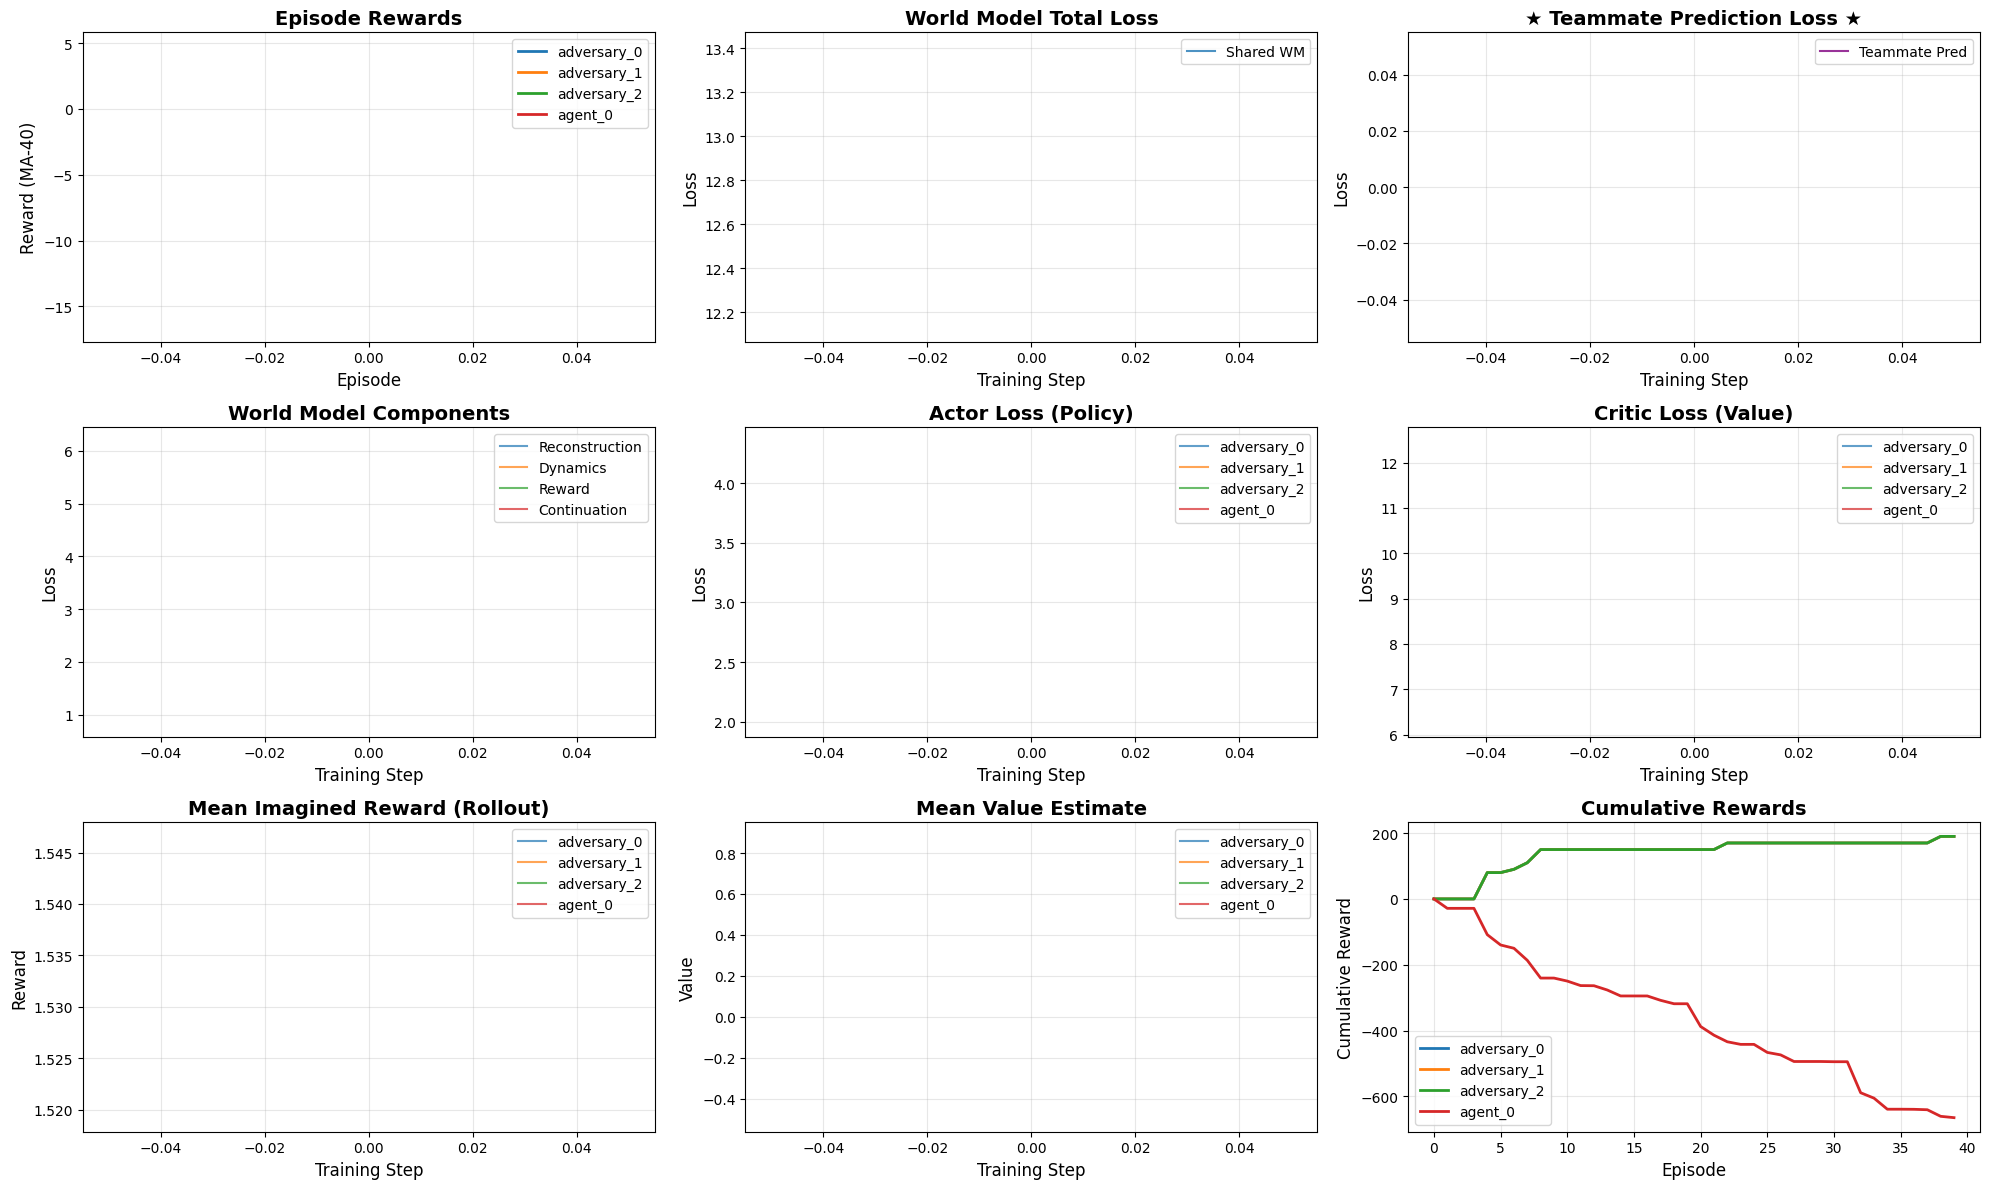

In [ ]:
# 強化された可視化（9パネル詳細版）
print("=" * 70)
print("ENHANCED TRAINING VISUALIZATION (9-Panel)")
print("=" * 70)
plot_training_progress(episode_rewards, training_metrics, save_path='results/training_curves_enhanced.png')

## 6. 訓練結果の可視化


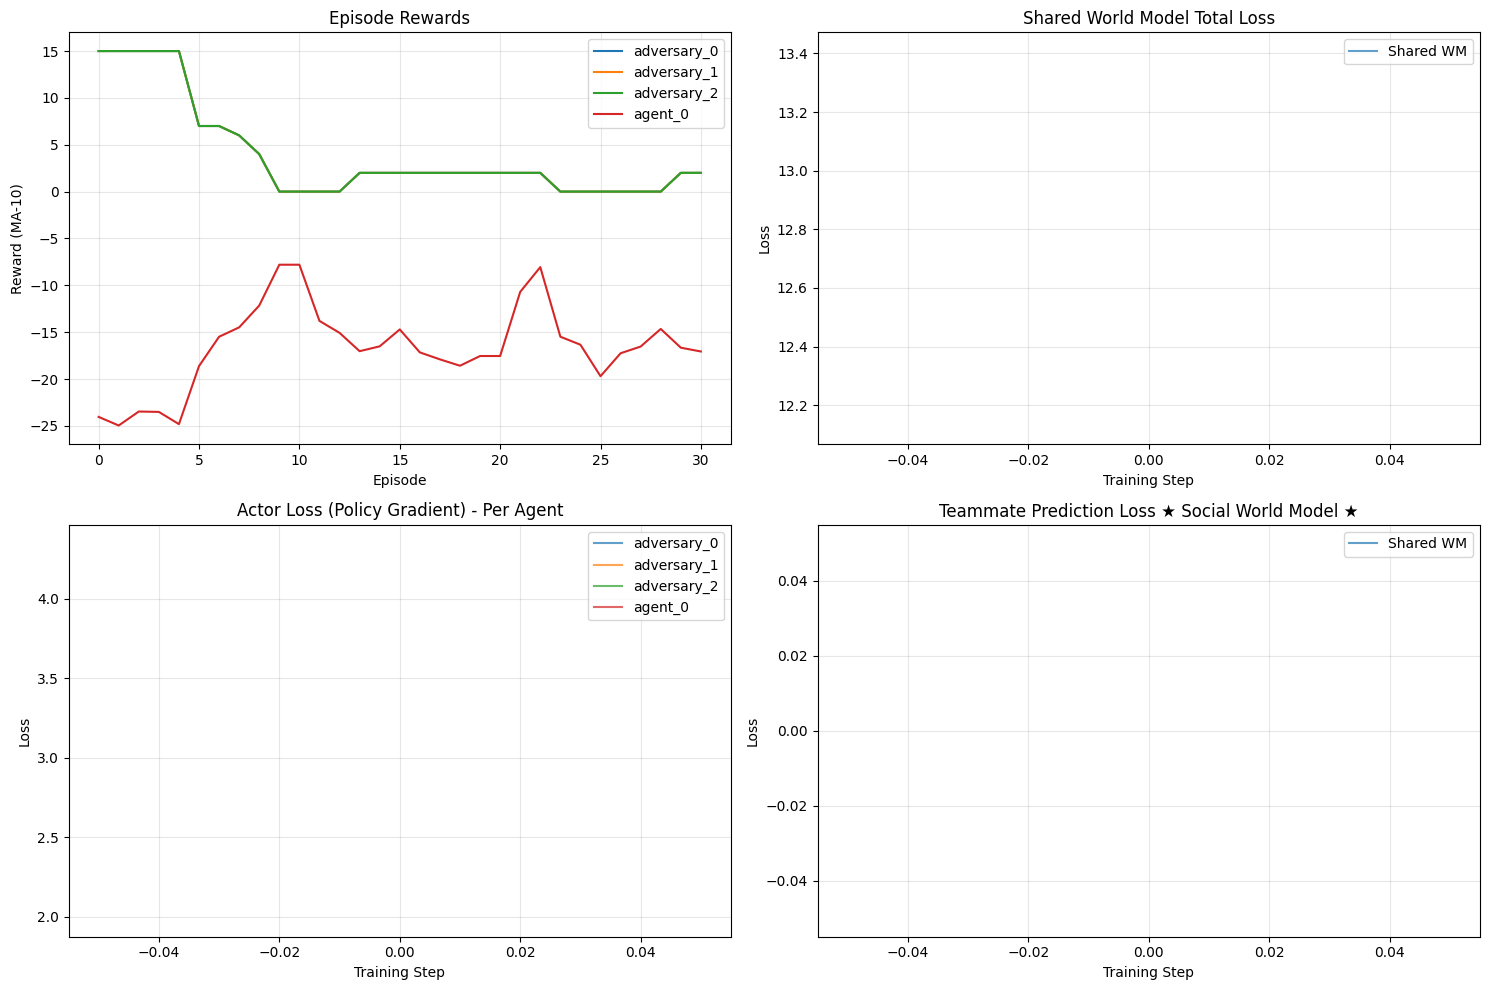

Training curves saved to results/training_curves.png


In [ ]:
# 学習曲線のプロット
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Episode rewards
ax = axes[0, 0]
for name, rewards in episode_rewards.items():
    if len(rewards) > 0:
        # Moving average
        window = min(10, len(rewards))
        if len(rewards) >= window:
            ma_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax.plot(ma_rewards, label=name)
ax.set_xlabel('Episode')
ax.set_ylabel(f'Reward (MA-{window})')
ax.set_title('Episode Rewards')
ax.legend()
ax.grid(True, alpha=0.3)

# World model losses (now shared across all agents)
ax = axes[0, 1]
key = 'shared_wm_total_loss'
if key in training_metrics and len(training_metrics[key]) > 0:
    ax.plot(training_metrics[key], label='Shared WM', alpha=0.7)
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.set_title('Shared World Model Total Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Actor loss (per agent)
ax = axes[1, 0]
agent_names = list(episode_rewards.keys())
for name in agent_names:
    key = f'{name}_actor_loss'
    if key in training_metrics and len(training_metrics[key]) > 0:
        ax.plot(training_metrics[key], label=name, alpha=0.7)
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.set_title('Actor Loss (Policy Gradient) - Per Agent')
ax.legend()
ax.grid(True, alpha=0.3)

# Teammate prediction loss (now shared)
ax = axes[1, 1]
key = 'shared_wm_teammate_loss'
if key in training_metrics and len(training_metrics[key]) > 0:
    ax.plot(training_metrics[key], label='Shared WM', alpha=0.7)
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.set_title('Teammate Prediction Loss ★ Social World Model ★')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print('Training curves saved to results/training_curves.png')


## 7. まとめと今後の展望

### 実装した内容

本Notebookでは、MATWM (Multi-Agent Transformer World Model) を simple_tag 環境に実装しました。

#### 主要コンポーネント:

1. **World Model**
   - **Encoder/Decoder**: Categorical VAE による潜在表現学習
   - **Dynamics Model**: Transformer による次状態予測
   - **Reward Predictor**: Two-hot symlog encoding による報酬予測
   - **Continuation Predictor**: エピソード継続の予測
   - **Teammate Predictor ★**: 他エージェント行動の予測（社会的世界モデルのコア）

2. **Agent (Actor-Critic)**
   - Actor Network: 方策学習
   - Critic Network: 価値関数学習（Semi-centralized）
   - Imagination-based Training: 世界モデルによる想像上の軌道での学習

3. **Training Strategy**
   - Prioritized Replay Buffer: 最近の経験を重視
   - Action Scaling: エージェント識別のための行動空間スケーリング
   - Decentralized Execution: 実行時は分散的

---

### MATWMの特徴

#### サンプル効率の向上

- **Imagination Rollout**: 実環境1ステップから15ステップ分の学習
- **目標**: 100K環境ステップで良好な性能（従来手法の1/10以下）

#### 社会的世界モデル

- **Teammate Predictor**により、他エージェントの行動を予測
- **非定常性の軽減**: 他エージェントの方策変化に対応
- **協調・競争**: good agentはadversariesの動きを予測して逃げる、adversariesは協調して捕まえる

---

### 今後の改善案

#### 1. γ-Progress Curiosity の導入

Active World Model Learning の手法を導入し、探索を改善:

```python
class ProgressCuriosity:
    def compute_intrinsic_reward(self, z_current, z_next_pred, z_next_actual):
        # 予測誤差の改善度を報酬として付与
        prediction_error = F.mse_loss(z_next_pred, z_next_actual)
        progress = self.prev_error - prediction_error
        intrinsic_reward = torch.clamp(progress, 0, 1)
        return intrinsic_reward
```

#### 2. Theory of Mind の強化

より高度な社会的推論:

- 他エージェントの意図推定
- 信念・欲求・意図(BDI)モデルの組み込み
- Recursive reasoning（「相手は自分をどう思っているか」）

#### 3. Communication Module

エージェント間通信の追加:

- メッセージ passing機構
- Attention-based communication
- Differentiable communication

#### 4. 階層的プランニング

- High-level goal selection
- Low-level action execution
- Feudal RL との統合

#### 5. Self-Play

- Adversarial self-play for robustness
- Population-based training
- Curriculum learning

---

### 参考文献

1. **MATWM**: Deihim, A., Alonso, E., & Apostolopoulou, D. (2025). *Transformer World Model for Sample Efficient Multi-Agent Reinforcement Learning*. arXiv:2506.18537.

2. **Active World Model Learning**: [γ-progress curiosityによる探索改善]

3. **STORM**: [MATWMの基盤となる単一エージェント世界モデル]

4. **Dreamer V3**: Hafner, D., et al. (2023). *Mastering Diverse Domains through World Models*.

5. **PettingZoo**: Terry, J. K., et al. (2021). *PettingZoo: Gym for Multi-Agent Reinforcement Learning*.

---

### 実装ファイル

- `matwm_implementation.py`: World Model コンポーネント
- `matwm_agent.py`: 完全なエージェント実装
- `2026_MATWM_simple_tag_Implementation.ipynb`: 本Notebook

---

**実装完了!** 🎉

社会的世界モデルを用いたマルチエージェント強化学習の実装が完了しました。Teammate Predictorにより、エージェントは他者の行動を予測し、より効率的に協調・競争することが可能になります。


## 7. まとめと今後の展望

### 実装した内容

本Notebookでは、MATWM (Multi-Agent Transformer World Model) を simple_tag 環境に実装しました。

#### 主要コンポーネント:

1. **World Model**
   - **Encoder/Decoder**: Categorical VAE による潜在表現学習
   - **Dynamics Model**: Transformer による次状態予測
   - **Reward Predictor**: Two-hot symlog encoding による報酬予測
   - **Continuation Predictor**: エピソード継続の予測
   - **Teammate Predictor ★**: 他エージェント行動の予測（社会的世界モデルのコア）

2. **Agent (Actor-Critic)**
   - Actor Network: 方策学習
   - Critic Network: 価値関数学習（Semi-centralized）
   - Imagination-based Training: 世界モデルによる想像上の軌道での学習

3. **Training Strategy**
   - Prioritized Replay Buffer: 最近の経験を重視
   - Action Scaling: エージェント識別のための行動空間スケーリング
   - Decentralized Execution: 実行時は分散的

---

### MATWMの特徴

#### サンプル効率の向上

- **Imagination Rollout**: 実環境1ステップから15ステップ分の学習
- **目標**: 100K環境ステップで良好な性能（従来手法の1/10以下）

#### 社会的世界モデル

- **Teammate Predictor**により、他エージェントの行動を予測
- **非定常性の軽減**: 他エージェントの方策変化に対応
- **協調・競争**: good agentはadversariesの動きを予測して逃げる、adversariesは協調して捕まえる

---

### 今後の改善案

#### 1. γ-Progress Curiosity の導入

Active World Model Learning の手法を導入し、探索を改善:

```python
class ProgressCuriosity:
    def compute_intrinsic_reward(self, z_current, z_next_pred, z_next_actual):
        # 予測誤差の改善度を報酬として付与
        prediction_error = F.mse_loss(z_next_pred, z_next_actual)
        progress = self.prev_error - prediction_error
        intrinsic_reward = torch.clamp(progress, 0, 1)
        return intrinsic_reward
```

#### 2. Theory of Mind の強化

より高度な社会的推論:

- 他エージェントの意図推定
- 信念・欲求・意図(BDI)モデルの組み込み
- Recursive reasoning（「相手は自分をどう思っているか」）

#### 3. Communication Module

エージェント間通信の追加:

- メッセージ passing機構
- Attention-based communication
- Differentiable communication

#### 4. 階層的プランニング

- High-level goal selection
- Low-level action execution
- Feudal RL との統合

#### 5. Self-Play

- Adversarial self-play for robustness
- Population-based training
- Curriculum learning

---

### 参考文献

1. **MATWM**: Deihim, A., Alonso, E., & Apostolopoulou, D. (2025). *Transformer World Model for Sample Efficient Multi-Agent Reinforcement Learning*. arXiv:2506.18537.

2. **Active World Model Learning**: [γ-progress curiosityによる探索改善]

3. **STORM**: [MATWMの基盤となる単一エージェント世界モデル]

4. **Dreamer V3**: Hafner, D., et al. (2023). *Mastering Diverse Domains through World Models*.

5. **PettingZoo**: Terry, J. K., et al. (2021). *PettingZoo: Gym for Multi-Agent Reinforcement Learning*.

---

### 実装ファイル

- `matwm_implementation.py`: World Model コンポーネント
- `matwm_agent.py`: 完全なエージェント実装
- `2026_MATWM_simple_tag_Implementation.ipynb`: 本Notebook

---

**実装完了!** 🎉

社会的世界モデルを用いたマルチエージェント強化学習の実装が完了しました。Teammate Predictorにより、エージェントは他者の行動を予測し、より効率的に協調・競争することが可能になります。
